In [1]:
import os.path as osp
import os
import sys
sys.path.append('./laughter')
from laughter_detection import LaughterDetection
from face_extractor.face_extractor import FaceExtractor
from recognition.face_recog import FaceRecognizer
from final_shorts.final_timeline import make_final_timeline
from moviepy.editor import *

## assign file path

In [2]:
VIDEO_PATH = '/opt/ml/project/input_dir/video/video_2_0_1080.mp4'
WAV_PATH = '/opt/ml/project/input_dir/wav/wav_2_0'
LAUGHTER_MODEL_PATH = '/opt/ml/project/model/laughter'
CLUSTER_IMG_SAVE_PATH = '/opt/ml/project/output_dir/cluster/video_2_0'
SHORTS_SAVE_PATH = '/opt/ml/project/output_dir/shorts/'
SHORTS_NAME = 'Video_2_0_'

## laughter detection

In [3]:
shorts_timeline = LaughterDetection(video_path=VIDEO_PATH, wav_path=WAV_PATH, ml_path=LAUGHTER_MODEL_PATH)

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

In [4]:
shorts_timeline

[(236.12, 268.24, 0.11),
 (397.26, 432.15, 0.18),
 (439.85, 480.89, 0.66),
 (496.29, 541.45, 0.99),
 (571.05, 602.87, 0.29),
 (743.64, 792.03, 0.08),
 (795.5, 832.06, 0.71),
 (867.69, 923.9, 0.05),
 (935.33, 978.29, 0.44),
 (982.85, 1001.73, 0.04)]

## clustering

In [5]:
extractor = FaceExtractor(VIDEO_PATH,None,CLUSTER_IMG_SAVE_PATH,threshold=0.63,stop=1000,face_cnt=350)
final_clusters = extractor.cluster_video()

--------------------------------------------------------------------------------
[Source Video File]: /opt/ml/project/input_dir/video/video_2_0_1080.mp4
[Frame resolution H x W]: (1080.0 x 1920.0)
[FPS]: 29.97
[Total number of frames]: 30208
[Total number of seconds]: 1007
[Similiarty Threshold]: 0.63
[Number of target faces for clustering]: 350
face & cloth weights: [1, 0.7]
sim_threshold: 0.63
face_cnt: 350
min_csize: 10
use merging: False
--------------------------------------------------------------------------------
>>> Extracting fingerprints...
>>> Clustering fingerprints...
>>> Calculating average encoding and representative encoding...


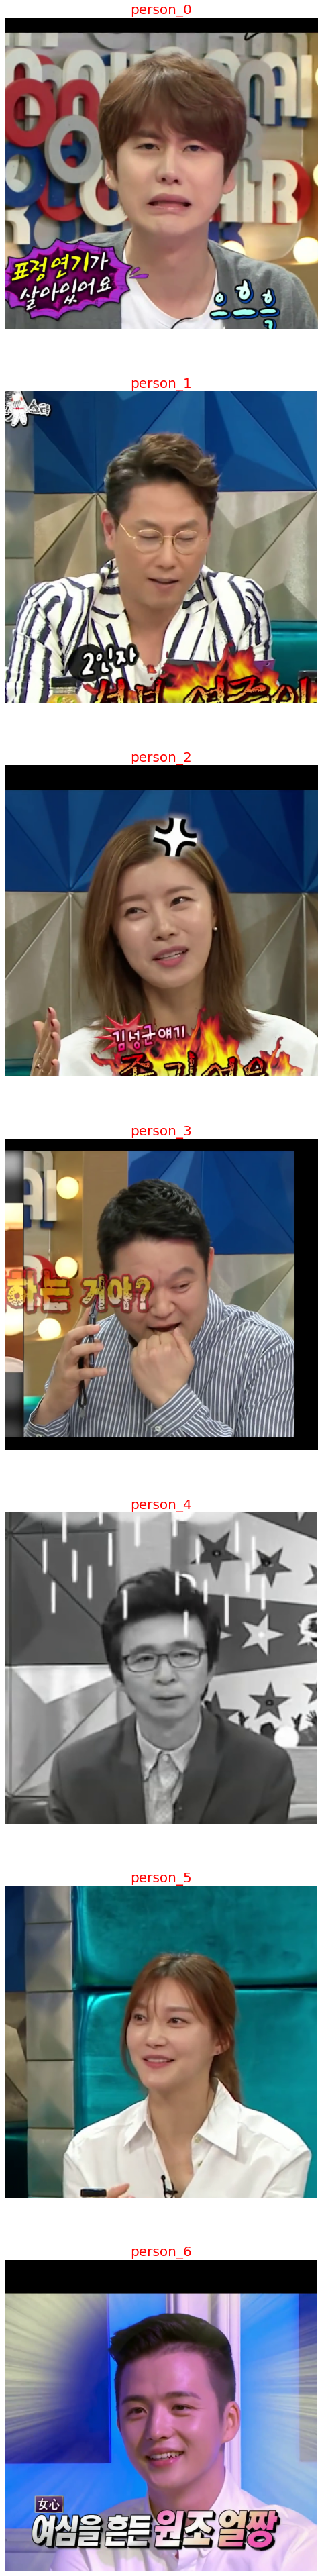

In [6]:
extractor.plot_clusters()

## recognition

In [7]:
target_people = ['person_0', 'person_1','person_2', 'person_3','person_4', 'person_5','person_6']
target_encoding = [final_clusters[person]['avg_encoding'] for person in target_people]

recognizer = FaceRecognizer(VIDEO_PATH,target_encoding=target_encoding,threshold=0.63)
timelines, output_frames = recognizer.recognize_faces()
people_timeline = recognizer.make_people_timeline(timelines, output_frames)

In [8]:
shorts_timeline

[(236.12, 268.24, 0.11),
 (397.26, 432.15, 0.18),
 (439.85, 480.89, 0.66),
 (496.29, 541.45, 0.99),
 (571.05, 602.87, 0.29),
 (743.64, 792.03, 0.08),
 (795.5, 832.06, 0.71),
 (867.69, 923.9, 0.05),
 (935.33, 978.29, 0.44),
 (982.85, 1001.73, 0.04)]

## make final timeline

In [47]:
shorts = []
for target_person_timeline in people_timeline:
    final_shorts_timeline = make_final_timeline(shorts_timeline,target_person_timeline)
    shorts.append(final_shorts_timeline)

In [48]:
shorts

[([], 0),
 ([(867.69, 923.9, 0.05, 0.326)], 56.21),
 ([(496.29, 541.45, 0.99, 0.363),
   (935.33, 978.29, 0.44, 0.338),
   (571.05, 602.87, 0.29, 0.369),
   (982.85, 1001.73, 0.04, 0.427)],
  138.82),
 ([(743.64, 792.03, 0.08, 0.465), (867.69, 923.9, 0.05, 0.362)], 104.6),
 ([], 0),
 ([(496.29, 541.45, 0.99, 0.605),
   (795.5, 832.06, 0.71, 0.597),
   (935.33, 978.29, 0.44, 0.476),
   (867.69, 923.9, 0.05, 0.421)],
  180.89),
 ([(496.29, 541.45, 0.99, 0.328)], 45.16)]

## save shorts

In [ ]:
if not osp.isdir(SHORTS_SAVE_PATH):
    os.makedirs(SHORTS_SAVE_PATH)

shorts_ind = 0
for short in shorts:
    if short[1] > 0:
        for start,end,_,_ in short[0]:
            SHORTS_PATH = SHORTS_SAVE_PATH + SHORTS_NAME + str(shorts_ind) + '.mp4'
            video = VideoFileClip(VIDEO_PATH).subclip(start,end).fx(vfx.fadein,1).fx(vfx.fadeout,1)
            video.write_videofile(SHORTS_PATH)
            shorts_ind += 1